This notebook analyses the output from a symmetric forcing, $\pm 8$ W m$^{-2}$ downwelling long wave flux, and $\pm 1.5$K SST.

When generating a new database, make sure to only load in the output directories. There's no point loading in the restarts! It will save a lot of compute time when computing the Dask arrays.

In [1]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit

from dask.distributed import Client

%matplotlib inline

In [2]:
client = Client()
display(client)

Client Scheduler: tcp://127.0.0.1:36119 Dashboard: /proxy/44939/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


In [3]:
### Generate new database

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt.db'

session = cc.database.create_session(db)

directory_list = ['/scratch/e14/mp2135/access-om2/archive/1deg_jra55_ryf_cont',
                     '/scratch/e14/mp2135/access-om2/archive/1deg_jra55_ryf_rcp45cool',
                     '/scratch/e14/mp2135/access-om2/archive/1deg_jra55_ryf_rcp45warm']

In [13]:
cc.querying.get_experiments(session)

,experiment,ncfiles
0,1deg_jra55_ryf_cont,42207
1,1deg_jra55_ryf_rcp45cool,47726
2,1deg_jra55_ryf_rcp45warm,47640


In [5]:
# Control

control_expt = '1deg_jra55_ryf_cont'
control = cc.querying.get_variables(session, experiment = control_expt)

temp_control = cc.querying.getvar(control_expt, 'temp', session, frequency = '1 monthly').chunk(chunks='auto')
 # [:-1] to remove 2200-01-01:
GAT_control = cc.querying.getvar(control_expt, 'temp_global_ave', session)[:-1].chunk(chunks=3650).load().groupby('time.year').mean('time')
SST_control = cc.querying.getvar(control_expt, 'temp_surface_ave', session)[:-1].chunk(chunks=3650).load().groupby('time.year').mean('time')

In [8]:
# Cool

cool_expt = '1deg_jra55_ryf_rcp45cool'
cool = cc.querying.get_variables(session, experiment = cool_expt)

temp_cool = cc.querying.getvar(cool_expt, 'temp', session, frequency = '1 monthly').chunk(chunks='auto')
GAT_cool = cc.querying.getvar(cool_expt, 'temp_global_ave', session)[:-1].chunk(chunks=3650).load().groupby('time.year').mean('time')
SST_cool = cc.querying.getvar(cool_expt, 'temp_surface_ave', session)[:-1].chunk(chunks=3650).load().groupby('time.year').mean('time')

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [9]:
# Warm

warm_expt = '1deg_jra55_ryf_rcp45warm'
warm = cc.querying.get_variables(session, experiment = warm_expt)

temp_warm = cc.querying.getvar(warm_expt, 'temp', session, frequency = '1 monthly').chunk(chunks='auto')
GAT_warm = cc.querying.getvar(warm_expt, 'temp_global_ave', session)[:-1].chunk(chunks=3650).load().groupby('time.year').mean('time')
SST_warm = cc.querying.getvar(warm_expt, 'temp_surface_ave', session)[:-1].chunk(chunks=3650).load().groupby('time.year').mean('time')

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [10]:
### Dedrift using a cubic

def cubic(t, a, b, c, d):
    return a * t**3 + b * t**2 + c * t + d

t = GAT_control['year'].values
popt, pcov = curve_fit(cubic, t, GAT_control[:,0])
GAT_trend = cubic(t, *popt)

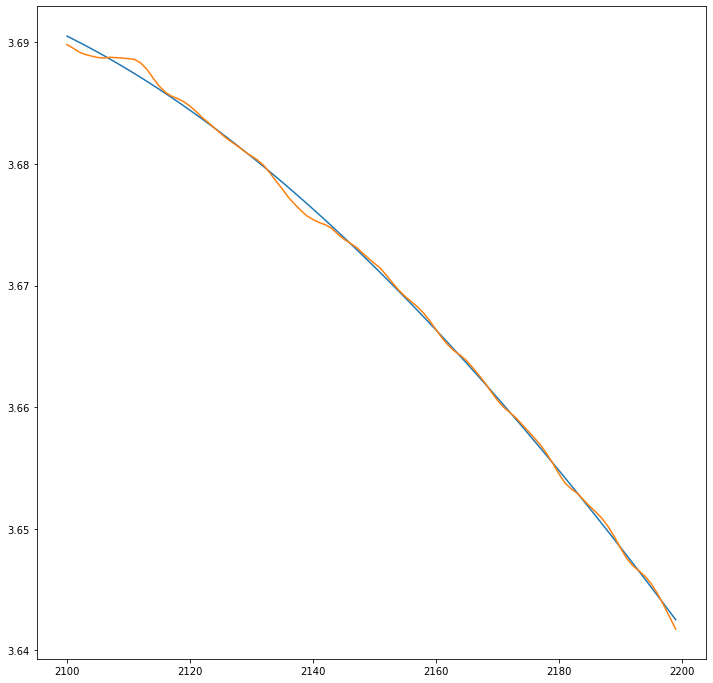

In [14]:
plt.figure(figsize=(12,12))

plt.plot(t, GAT_trend)
plt.plot(t, GAT_control)

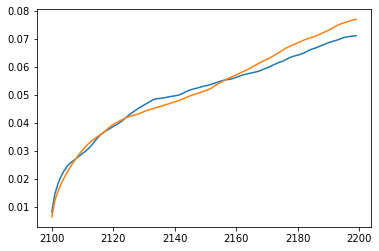

In [15]:
# plt.plot(GAT_trend, t)
# plt.plot(GAT_control.values[:,0], t)
plt.plot(t, -1*(GAT_cool[:,0] - GAT_trend))
plt.plot(t, (GAT_warm[:,0] - GAT_trend))

<Figure size 936x648 with 0 Axes>

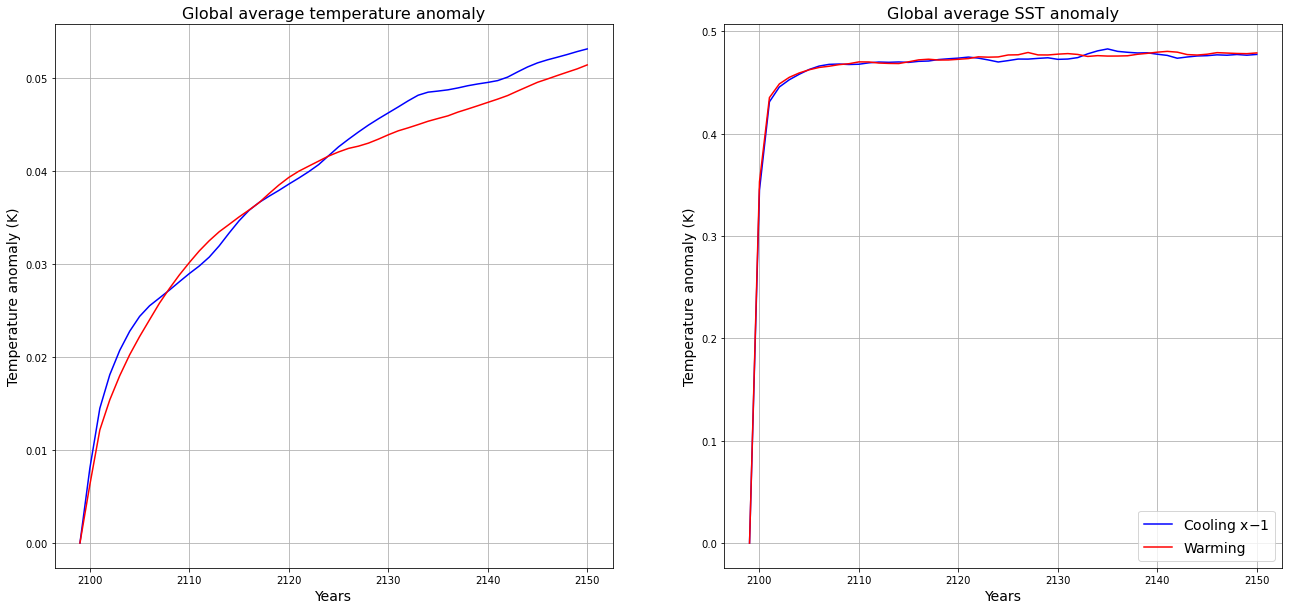

In [18]:
plt.figure(figsize = (13,9))

# GAT
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(22,10))
zero = xr.DataArray(data=[0], dims='year', coords={"year": [2099]})

GAT_cool_anom_plotting = xr.concat([zero, (GAT_cool[:,0] - GAT_trend)], dim='year')
GAT_warm_anom_plotting = xr.concat([zero, (GAT_warm[:,0] - GAT_trend)], dim='year')
(-1*GAT_cool_anom_plotting[:52]).plot(ax = axs[0], color='b', label='Cooling x$-1$')
GAT_warm_anom_plotting[:52].plot(ax = axs[0], color='r', label='Warming')
axs[0].grid()
axs[0].set_title('Global average temperature anomaly', fontsize=16)
axs[0].set_xlabel('Years', fontsize=14)
axs[0].set_ylabel('Temperature anomaly (K)', fontsize=14)


# SST
SST_cool_anom_plotting = xr.concat([zero, SST_cool[:,0] - SST_control[:,0]], dim='year')
SST_warm_anom_plotting = xr.concat([zero, SST_warm[:,0] - SST_control[:,0]], dim='year')
(-1*SST_cool_anom_plotting[:52]).plot(ax = axs[1], color='b', label='Cooling x$-1$')
SST_warm_anom_plotting[:52].plot(ax = axs[1], color='r', label='Warming')
axs[1].grid()
axs[1].legend(fontsize=14, loc='lower right')
axs[1].set_title('Global average SST anomaly', fontsize=16)
axs[1].set_xlabel('Years', fontsize=14)
axs[1].set_ylabel('Temperature anomaly (K)', fontsize=14)
#plt.savefig('GAT_SST_no_humid.jpg')

## Surface heat fluxes

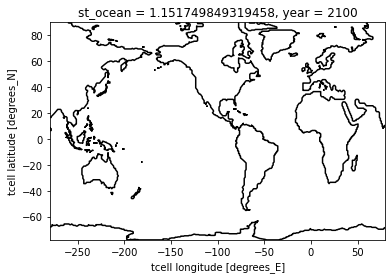

In [123]:
# Get land mask

dset = xr.merge([temp_control.groupby('time.year').mean(dim='time').isel(year = 0, st_ocean = 0)])
ds = dset
mask_ocean = 2 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isfinite(ds.temp)  
mask_land = 1 * np.ones((ds.dims['yt_ocean'], ds.dims['xt_ocean'])) * np.isnan(ds.temp)  
mask_array = mask_ocean + mask_land
mask_array.plot.contour(colors = 'k', levels = [2])

In [138]:
### Surface heat flux
# Using 'net_sfc_heating': "surface ocean heat flux coming through coupler and mass transfer"
var = 'net_sfc_heating'

expt = '1deg_jra55_ryf_cont'
net_sfc_cont = cc.querying.getvar(expt, var, session).chunk(chunks='auto') 

expt = '1deg_jra55_ryf_rcp45cool'
net_sfc_cool = cc.querying.getvar(expt, var, session).chunk(chunks='auto')

expt = '1deg_jra55_ryf_rcp45warm'
net_sfc_warm = cc.querying.getvar(expt, var, session).chunk(chunks='auto')

In [140]:
net_sfc_cont

<xarray.DataArray 'net_sfc_heating' (time: 1140, yt_ocean: 300, xt_ocean: 360)>
dask.array<rechunk-merge, shape=(1140, 300, 360), dtype=float32, chunksize=(285, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * time      (time) object 2100-01-16 12:00:00 ... 2199-12-16 12:00:00
Attributes:
    long_name:      surface ocean heat flux coming through coupler and mass t...
    units:          Watts/m^2
    valid_range:    [-10000.  10000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t

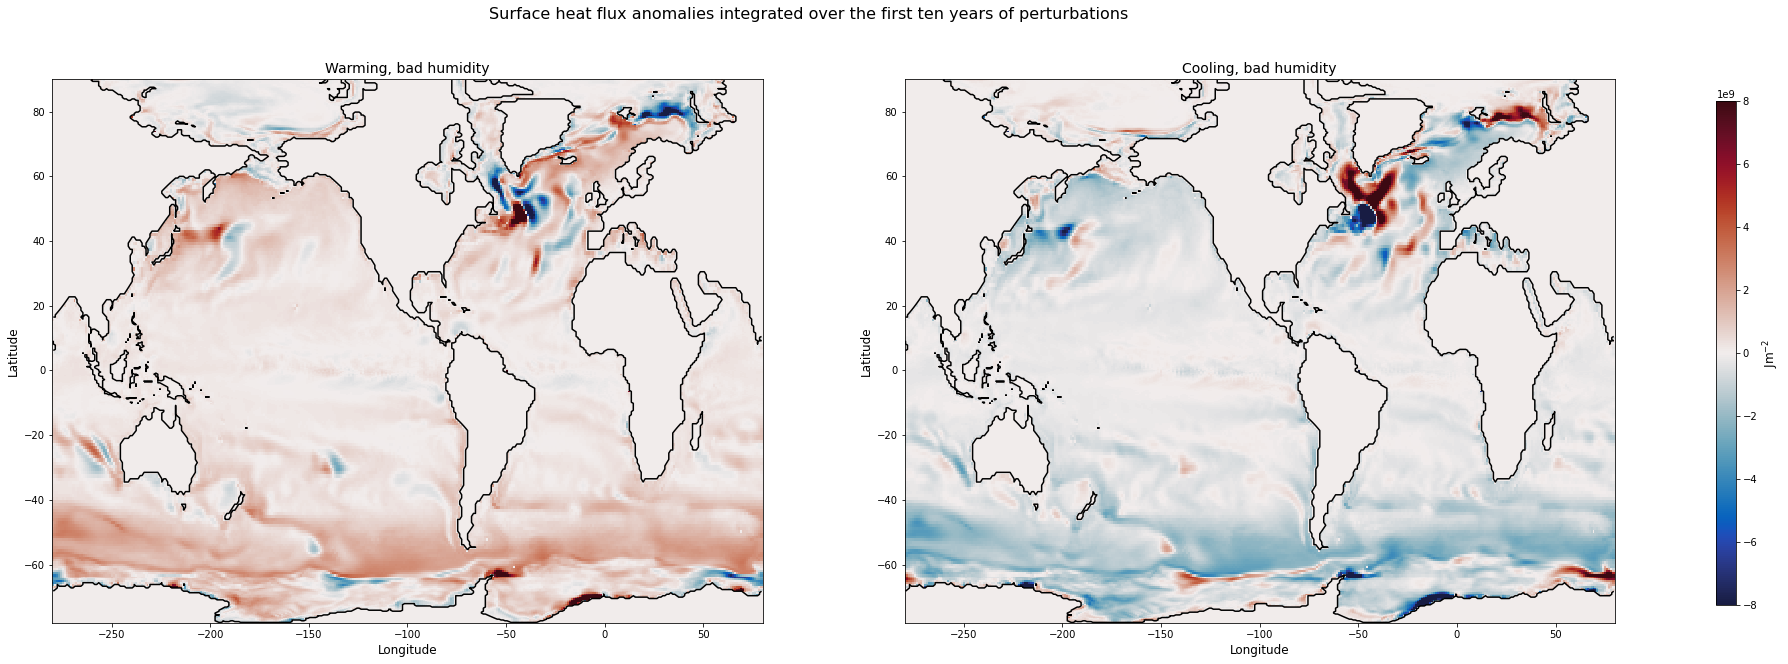

In [148]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(28, 10))
plt.suptitle('Surface heat flux anomalies integrated over the first ten years of perturbations', fontsize=16)
yr_10 = '2110-01-01'

month_length = net_sfc_cont.time.dt.days_in_month
p1 = ((net_sfc_warm - net_sfc_cont) * month_length * 24 * 3600).sel(time = slice(None, yr_10)).sum('time').plot(ax = axs[0], cmap = cm.cm.balance, vmin = -8e9, vmax = 8e9, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[0])
axs[0].set_title('Warming, bad humidity', fontsize=14)
axs[0].set_ylabel('Latitude', fontsize=12)
axs[0].set_xlabel('Longitude', fontsize=12)

p2 = ((net_sfc_cool - net_sfc_cont) * month_length * 24 * 3600).sel(time = slice(None, yr_10)).sum('time').plot(ax = axs[1], cmap = cm.cm.balance, vmin = -8e9, vmax = 8e9, add_colorbar = False)
mask_array.plot.contour(colors = 'k', levels = [2], ax = axs[1])
axs[1].set_title('Cooling, bad humidity', fontsize=14)
axs[1].set_ylabel('Latitude', fontsize=12)
axs[1].set_xlabel('Longitude', fontsize=12)

cb_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
cbar = fig.colorbar(p2, cax = cb_ax)
cbar.ax.set_ylabel('Jm$^{-2}$', fontsize = 12)
plt.savefig('SHF_10_no_humid.jpg')